In [1]:
import censusdata
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
acs = censusdata.download('acs5' #Dataset to use
                          ,2018, # year 2014-2018, the most recent one
                          censusdata.censusgeo([('state', '17'), ('county', '031'), ('tract',"*")]), #Geography
                          ['DP02_0065PE', #Pct_bach
                           'DP03_0062E', #income
                           'DP05_0001E', #total_pop
                           'DP05_0004E', #sex_ratio
                           'DP05_0037PE', #pct_white
                           'DP05_0018E', #median_age
                           'DP04_0058PE', #no-car
                           'DP03_0005PE' #unemplo
                          ],
                         tabletype='profile')

acs.columns=['pct_bach','median_income','total_pop','sex_ratio','pct_white',
             'median_age','pct_no_car','pct_unemp']



age = censusdata.download('acs5', 2018, 
                           censusdata.censusgeo([('state', '17'), ('county', '031'), ('tract',"*")]), #Geography
                                   ['B01001_007E', #M18/19
                                    'B01001_008E', #M20
                                    'B01001_009E', #M21
                                    'B01001_010E', #M22-24
                                    'B01001_011E', #M25-29
                                    'B01001_031E', #F18/19
                                    'B01001_032E', #F20
                                    'B01001_033E', #F21
                                    'B01001_034E', #F22-24
                                    'B01001_035E' #F25-29
                                   ])

acs["age_18_29"] = age.sum(axis = 1)
acs["pct_age_18_29"] = acs["age_18_29"]/acs["total_pop"] * 100

censusdata.export.exportcsv("data/acs.csv", acs)
acs_df = pd.read_csv("data/acs.csv")
acs_df["GEOID"] = acs_df.state.astype(str) + acs_df.county.astype(str).str.zfill(3) + acs_df.tract.astype(str).str.zfill(6)
acs_df["GEOID"] = acs_df["GEOID"]

In [3]:
SLD = pd.read_csv("data/SLD_trac.csv")
SLD["TRACTCE"] = "17031" + SLD["TRACTCE"].astype(str).str.zfill(6)

In [4]:
SLD["TRACTCE"]

0        17031000100
1        17031000101
2        17031000102
3        17031000103
4        17031000104
            ...     
16539    17031985000
16540    17031985100
16541    17031985300
16542    17031985500
16543    17031989100
Name: TRACTCE, Length: 16544, dtype: object

In [5]:
chicago = gpd.read_file("data/shp/geo_export_3890de09-5807-41da-984a-01b79afdfc2c.shp")

chicago.drop(['notes'], axis=1,inplace=True)

chicago = chicago.to_crs("EPSG:32616")

In [6]:
chicago.geoid10

0      17031842400
1      17031840300
2      17031841100
3      17031841200
4      17031839000
          ...     
796    17031070400
797    17031070500
798    17031130300
799    17031292200
800    17031630900
Name: geoid10, Length: 801, dtype: object

In [7]:
chicago = chicago.merge(acs_df,left_on="geoid10",right_on="GEOID")
chicago = chicago.merge(SLD,left_on="geoid10",right_on="TRACTCE")

chicago = chicago[chicago['total_pop']>500]

In [8]:
metro = gpd.read_file("data/CTA_RailStations/CTA_RailStations.shp").to_crs("epsg:4326")
chicago_4326 = chicago.to_crs("epsg:4326")
chicago['metro'] = metro["geometry"].apply(lambda geom: chicago_4326["geometry"].contains(geom)).sum(axis=0)
chicago['metro'] = np.where(chicago['metro']<0.5,0,1)

<AxesSubplot:>

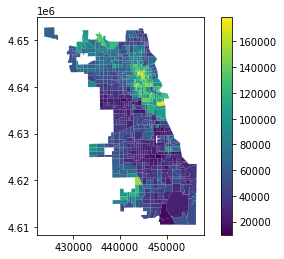

In [12]:
chicago.plot(column='median_income',legend=True)

In [10]:
chicago.to_file("data/shp/acs_tracts.shp")

C:\Users\Z-Li\AppData\Local\Temp/ipykernel_13964/1106809178.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  chicago.to_file("data/shp/acs_tracts.shp")


In [11]:
#import dask.dataframe as dd
#df = dd.read_csv('data/Transportation_Network_Providers_-_Trips.csv')

In [12]:
%%time
d = 10
k = 9

def keep(x):
    if x==0:
        return True
    if (x-1) % d == k:
        return True

df = pd.read_csv("data/Transportation_Network_Providers_-_Trips.csv", header=0, skiprows=lambda x: not keep(x))

Wall time: 3min 28s


In [13]:
#df.head()

In [14]:
%%time
df['start_datetime'] = pd.to_datetime(df["Trip Start Timestamp"],format='%m/%d/%Y %I:%M:%S %p')

df['month'] = df['start_datetime'].dt.month

Wall time: 49.8 s


In [15]:
df['year'] = df['start_datetime'].dt.year

In [16]:
df = df[df.year==2019]

In [17]:
df.shape

(11182684, 24)

In [18]:
df['Shared Trip Authorized'].describe()

count     11182684
unique           2
top          False
freq       8948631
Name: Shared Trip Authorized, dtype: object

In [19]:
df = df[df['Trip Miles']<=50]
df = df[df['Trip Miles']>=1]
df = df[df['Trip Seconds']<=3600*2]
df = df[df['Trip Seconds']>=5*60]
df = df[df['Fare']>=2.5]
df = df[df['Fare']<=50]

df['fare_no_tip'] = df['Fare'] + np.round(df['Additional Charges'],0)

df = df[df.fare_no_tip >= 5]
df = df[df.fare_no_tip <= 40]

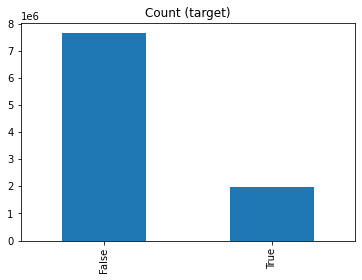

In [20]:
df['Shared Trip Authorized'].value_counts().plot(kind='bar', title='Count (target)');

In [21]:
df.dropna(inplace=True)

In [22]:
df["end_geoid"] = df["Dropoff Census Tract"].astype(np.int64).astype(str)
df["start_geoid"] = df["Pickup Census Tract"].astype(np.int64).astype(str)

In [23]:
%%time

df = df.merge(chicago,left_on="end_geoid", right_on="GEOID")

df = df.merge(chicago,left_on="start_geoid", right_on="GEOID")

Wall time: 25.7 s


In [24]:
df.drop(['geometry_y'], axis=1,inplace=True)
df.drop(['geometry_x'], axis=1,inplace=True)

In [25]:
df.shape

(6002793, 93)

In [26]:
df["shared"] = df["Shared Trip Authorized"]
df["trip_seconds"] = df["Trip Seconds"]
df['trip_miles'] = df["Trip Miles"]

df['start_dayweek'] = df['start_datetime'].dt.dayofweek

df['day'] = df['start_datetime'].dt.day
df['hour'] = df['start_datetime'].dt.hour

df['pick_long'] = df['Pickup Centroid Longitude']
df['pick_lat'] = df['Pickup Centroid Latitude']
df['drop_long'] = df['Dropoff Centroid Longitude']
df['drop_lat'] = df['Dropoff Centroid Latitude']

#df['ln_total_pop_x'] = np.log(df['total_pop_x'])
#df['ln_total_pop_y'] = np.log(df['total_pop_y'])

df['yyyymm'] = (df['year'] - 2019)*12 + df['month']

In [27]:
df['work_day'] = 1

In [28]:
#weekends
df.loc[df.start_dayweek >= 6, 'work_day'] = 0

In [29]:
#holidays
df.loc[(df.month == 1) & (df.day==1), 'work_day'] = 0
df.loc[(df.month == 1) & (df.day==21), 'work_day'] = 0
df.loc[(df.month == 2) & (df.day==12), 'work_day'] = 0
df.loc[(df.month == 2) & (df.day==18), 'work_day'] = 0
df.loc[(df.month == 3) & (df.day==4), 'work_day'] = 0
df.loc[(df.month == 5) & (df.day==27), 'work_day'] = 0
df.loc[(df.month == 7) & (df.day==4), 'work_day'] = 0
df.loc[(df.month == 9) & (df.day==2), 'work_day'] = 0
df.loc[(df.month == 10) & (df.day==14), 'work_day'] = 0
df.loc[(df.month == 11) & (df.day==11), 'work_day'] = 0
df.loc[(df.month == 11) & (df.day==28), 'work_day'] = 0
df.loc[(df.month == 12) & (df.day==25), 'work_day'] = 0

## NOAA

In [30]:
noaa = pd.read_csv("data/hourly_climate.csv")

In [31]:
df = df.merge(noaa,how="left",on=['year','month','day','hour'])

## Distance-based features

In [32]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def manhattan(lat1, lng1, lat2, lng2):
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b


In [33]:
def compute_distance(df):
    
    dt = (41.8757,-87.6243)
    
    df['distance_haversine'] = haversine(df['pick_lat'].values, 
                                        df['pick_long'].values, 
                                        df['drop_lat'].values, 
                                        df['drop_long'].values)
    
    df['distance_manhattan'] = manhattan(df['pick_lat'].values, 
                                        df['pick_long'].values, 
                                        df['drop_lat'].values, 
                                        df['drop_long'].values)
    
    df['pick_dist_dt'] = haversine(df['pick_lat'].values, 
                                        df['pick_long'].values, 
                                        dt[0], dt[1])
    
    df['drop_dist_dt'] = haversine(dt[0],dt[1], 
                                        df['drop_lat'].values, 
                                        df['drop_long'].values)

In [34]:
compute_distance(df)

df['trip_direction'] = np.degrees(np.arctan2((df['drop_lat'] - df['pick_lat']),(df['drop_long'] - df['pick_long'])))


In [35]:
df['ln_pop_den_x'] = (np.log(df['total_pop_x']/df['area_upr_x']))
df['ln_pop_den_y'] = (np.log(df['total_pop_y']/df['area_upr_y']))

df['pct_non_white_x'] = 100 - df['pct_white_x']
df['pct_non_white_y'] = 100 - df['pct_white_y']


In [36]:
np.random.seed(111)
df['test'] = np.random.binomial(1, 0.2, size=df.shape[0])

In [37]:
df['test'].sum()

1200359

## Matching

In [38]:
%%time
'''
df_plot = df.groupby(['shared', 'hour','month','work_day','test',
                                 'Pickup Census Tract','Dropoff Census Tract']).mean().reset_index()

df_match = df_plot[['Pickup Census Tract','Dropoff Census Tract','shared','hour','month','work_day',
                    'test','Trip Seconds','Trip Miles','Fare']][df_plot.shared == False].drop('shared',axis=1)
df_match = df_match[df_match.test==0].drop('test',axis=1)

df_match.columns = ['Pickup Census Tract','Dropoff Census Tract','hour','month','work_day',
                    'ave_solo_secs','ave_solo_miles','ave_solo_fare']

df = df.merge(df_match,how='left',on=['Pickup Census Tract','Dropoff Census Tract','hour','month','work_day'])


df['detour_time'] = (df['Trip Seconds'] - df['ave_solo_secs'])/df['ave_solo_secs'] * 100
df['detour_dist'] = (df['Trip Miles'] - df['ave_solo_miles'])/df['ave_solo_miles'] * 100
df['discount_fare'] = (df['Fare'] - df['ave_solo_fare'])/df['ave_solo_fare']*100
'''

Wall time: 0 ns


"\ndf_plot = df.groupby(['shared', 'hour','month','work_day','test',\n                                 'Pickup Census Tract','Dropoff Census Tract']).mean().reset_index()\n\ndf_match = df_plot[['Pickup Census Tract','Dropoff Census Tract','shared','hour','month','work_day',\n                    'test','Trip Seconds','Trip Miles','Fare']][df_plot.shared == False].drop('shared',axis=1)\ndf_match = df_match[df_match.test==0].drop('test',axis=1)\n\ndf_match.columns = ['Pickup Census Tract','Dropoff Census Tract','hour','month','work_day',\n                    'ave_solo_secs','ave_solo_miles','ave_solo_fare']\n\ndf = df.merge(df_match,how='left',on=['Pickup Census Tract','Dropoff Census Tract','hour','month','work_day'])\n\n\ndf['detour_time'] = (df['Trip Seconds'] - df['ave_solo_secs'])/df['ave_solo_secs'] * 100\ndf['detour_dist'] = (df['Trip Miles'] - df['ave_solo_miles'])/df['ave_solo_miles'] * 100\ndf['discount_fare'] = (df['Fare'] - df['ave_solo_fare'])/df['ave_solo_fare']*100\n"

In [39]:
'''
df2 = df.groupby(['shared', 'hour', 'month','work_day','test',
                                 'Pickup Census Tract','Dropoff Census Tract']) \
       .agg({'shared':'size'})
df2.columns = ['trip_counts']
df2 = df2.reset_index()
df2 = df2.drop(['shared'],axis=1)

df2 = df2[df2.test==0]

df2 = df2.drop(['test'],axis=1)

df = df.merge(df2,how='left',on=['Pickup Census Tract','Dropoff Census Tract','hour','month','work_day'])

df.shape
'''

"\ndf2 = df.groupby(['shared', 'hour', 'month','work_day','test',\n                                 'Pickup Census Tract','Dropoff Census Tract'])        .agg({'shared':'size'})\ndf2.columns = ['trip_counts']\ndf2 = df2.reset_index()\ndf2 = df2.drop(['shared'],axis=1)\n\ndf2 = df2[df2.test==0]\n\ndf2 = df2.drop(['test'],axis=1)\n\ndf = df.merge(df2,how='left',on=['Pickup Census Tract','Dropoff Census Tract','hour','month','work_day'])\n\ndf.shape\n"

In [40]:
#df = df[df.trip_counts >= 10]

df.shape

(6002793, 119)

In [41]:
df.dropna(inplace=True)

In [42]:
df['rain'] = pd.cut(df.hour_prec, [-np.inf, 0.01, 0.1, 0.3, 2, +np.inf] , labels = [0,1,2,3,4]).astype(int)

## Balance

In [43]:
def balance(df, j):
        
    count_class_0, count_class_1 = df.shared.value_counts()

    df_class_0 = df[df['shared'] == 0]
    df_class_1 = df[df['shared'] == 1]

    df_class_0_under = df_class_0.sample(count_class_1)
    df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
    
    df_test_under.shape
    df_test_under.to_csv("trip_records_acs_" + str(d) + "_" + j + "_" + str(k) + ".csv")
    
    df_test_under.shared.value_counts().plot(kind='bar', title='Count (target)')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5894230 entries, 0 to 6002792
Columns: 120 entries, Trip ID to rain
dtypes: bool(2), datetime64[ns](1), float64(66), int32(4), int64(20), object(27)
memory usage: 5.1+ GB


In [ ]:
balance(df[df.test==0], 'train')

In [ ]:
balance(df[df.test==1], 'test')

In [ ]:
df_plot = df.groupby(['shared', 'hour']).size().reset_index().pivot(columns=
                                                                    'shared', index='hour', values=0)
df_plot.plot(kind='bar', stacked=True,figsize=(10,5))

In [ ]:
df_plot = df.groupby(['shared', 'yyyymm']).size().reset_index().pivot(columns=
                                                                    'shared', index='yyyymm', values=0)
df_plot.plot(kind='bar', stacked=True,figsize=(10,5))